In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

In [246]:
def merge_txt_files(data_path='data'):
    dfs = []
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        if file_path.endswith('.txt'):
            print(file_path)
            dfs.append(pd.read_csv(file_path, sep='\t'))
    df_concat = pd.concat(dfs)
    df_concat.to_csv(os.path.join('raw_data_merged.txt'), index=False, sep='\t')

def get_RT(traj):
    if sum(traj.ego_v<1):
        idx_bot_spawn = (traj.ego_v<0.9).to_numpy().nonzero()[0][0]+5 # assume 50 ms delay for bot spawn
        throttle = traj.iloc[idx_bot_spawn:, traj.columns.get_loc('throttle')]
        idx_response = idx_bot_spawn + (throttle>0.01).to_numpy().nonzero()[0][0]
        RT = traj.t[idx_response] - traj.t[idx_bot_spawn]
        idx_min_distance = np.argmin(traj.d_ego_bot[idx_bot_spawn:].values)
    else:
        idx_bot_spawn = -1
        idx_response = -1
        idx_min_distance = -1
        RT = -1
    return pd.Series({'idx_bot_spawn': idx_bot_spawn,
                      'idx_response': idx_response,
                      'idx_min_distance': idx_min_distance,
                      'RT': RT})

def get_data(data_file='raw_data_merged.txt'):
    data = pd.read_csv(data_file, sep='\t', index_col=['subj_id', 'session', 'route', 'intersection'])

    data.t /= 1000

    # we are only intersted in left turns
    data = data[data.turn_direction==1]

    # only consider parts of the trajectories near the target intersection
    data = data[abs(data.distance_to_intersection)<10]

    apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
    cols_to_smooth = ['ego_x', 'ego_y', 'ego_vx', 'ego_vy', 'ego_ax', 'ego_ay', 
                      'bot_x', 'bot_y', 'bot_vx', 'bot_vy', 'bot_ax', 'bot_ay']
    data.loc[:, cols_to_smooth] = (data.loc[:, cols_to_smooth].groupby(data.index.names).transform(apply_filter))

    data['ego_v'] = np.sqrt(data.ego_vx**2 + data.ego_vy**2)
    data['bot_v'] = np.sqrt(data.bot_vx**2 + data.bot_vy**2)

    data['ego_a'] = np.sqrt(data.ego_ax**2 + data.ego_ay**2)
    data['bot_a'] = np.sqrt(data.bot_ax**2 + data.bot_ay**2)
    
    data['d_ego_bot'] = np.sqrt((data.ego_x - data.bot_x)**2 + (data.ego_y - data.bot_y)**2)

    measures = data.groupby(data.index.names).apply(get_RT)
    
    # in one trial RT is zero because the driver didn't stop
    measures = measures[measures.RT>0]

    conditions = data.loc[:,['tta_condition', 'd_condition', 'v_condition']].groupby(data.index.names).first()
    measures = measures.join(conditions)
    

    data.loc[:,'t'] = data.t.groupby(data.index.names).transform(lambda t: (t-t.min()))

    return data, measures

In [3]:
merge_txt_files()

data\120_1_2019_08_20_15_35.txt
data\305_1_2019_08_20_14_43.txt


In [247]:
data, measures = get_data()
subjects = data.index.get_level_values(0).unique()

# column p(turn) ~ probability of turn is one if response is initatated before the minimum distance between the cars is reached
# measures['p(turn)'] = measures.RT < measures.tta_condition - 0.5
measures['p(turn)'] = measures.idx_min_distance > measures.idx_response
measures_turn = measures[measures['p(turn)']>0]

We only have very little data so far, 59 decisions from 2 pilot subjects. This data can only help to fine-tune the parameteres of the experiment setup, we cannot yet draw any conclusions regarding our hypotheses

In [229]:
measures.describe()

,idx_bot_spawn,idx_response,idx_min_distance,RT,tta_condition,d_condition,v_condition
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000
mean,69.864407,255.542373,380.932203,1.908153,4.372881,120.00000,28.152542
std,26.645474,136.802188,160.696315,1.427778,1.285171,30.62566,10.741177
min,6.000000,118.000000,0.000000,0.433000,3.000000,80.00000,13.000000
25%,50.000000,153.000000,318.500000,0.813500,3.000000,80.00000,20.000000
50%,70.000000,191.000000,367.000000,1.193000,4.000000,120.00000,26.000000
75%,93.000000,311.500000,428.500000,2.572500,6.000000,160.00000,35.000000
max,118.000000,692.000000,1017.000000,6.493000,6.000000,160.00000,53.000000


Let's take a look at an example trajectory

In [248]:
traj_id = (subjects[0],1,1,22)
traj = data.loc[traj_id]
idx_bot_spawn = int(measures.loc[traj_id, 'idx_bot_spawn'])
idx_response = int(measures.loc[traj_id, 'idx_response'])

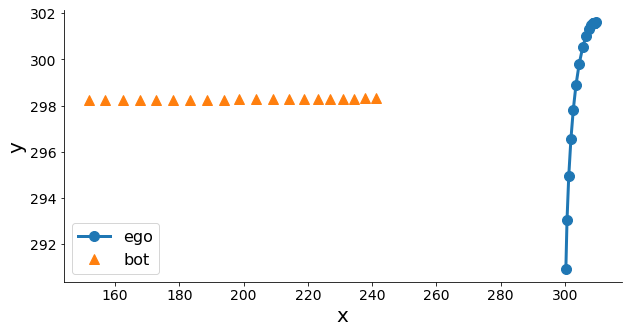

In [260]:
fig, ax1 = plt.subplots(1, figsize=(10,5))
ax1.plot(traj.ego_x[::20], traj.ego_y[::20], ls='-', lw=3, label='ego', marker='o')
ax1.plot(traj.bot_x[idx_bot_spawn+10::20], traj.bot_y[idx_bot_spawn+10::20], ls='', marker='^', lw=3, label='bot')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
legend = ax1.legend(loc='lower left')
tta = measures.loc[traj_id, 'tta_condition']
d = (np.sqrt((traj.ego_x[idx_bot_spawn]-traj.bot_x[idx_bot_spawn])**2 
             + (traj.ego_y[idx_bot_spawn]-traj.bot_y[idx_bot_spawn])**2))
v = d/tta
# legend.set_title('TTA=%.2fs, d=%im, v=%.2fm/s' % (tta, d, v))
# legend.get_title().set_fontsize('16')

To be able to determine the moment when the driver starts making a decision, I simply spawn the bot when the speed of the ego vehicle is below 1m/s. This results in a not-so-nice singularity at the moment the bot is spawned (see the spike in bot v), but given the time scale of the decision-making process (mean RT about 2 seconds), this probably doesn't influence the overall decision much. (however, we have to keep in mind that in actual traffic, there is no easy way to determine when the driver starts seeing the oncoming vehicle, so this uncertainty should be incorporated in the models in future somehow)

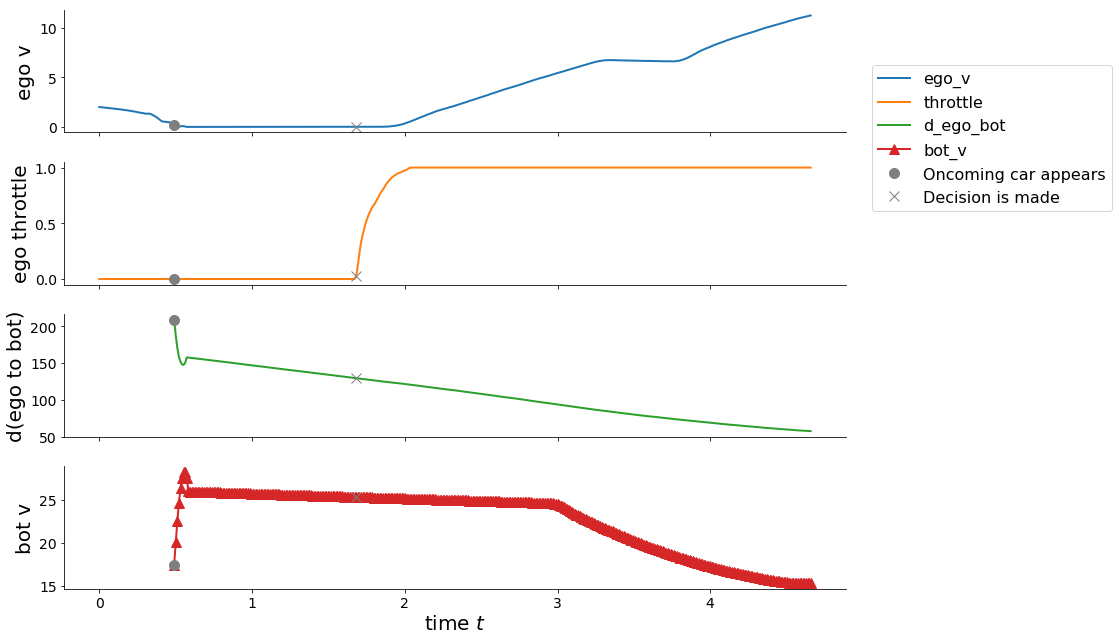

In [257]:
fig, axes = plt.subplots(4, 1, figsize=(12,9), sharex=True)
axes[0].plot(traj.t, traj.ego_v, color='C0')
axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color='C7', ls='', marker='o')
axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color='C7', ls='', marker='x')
axes[0].set_ylabel('ego v')

axes[1].plot(traj.t, traj.throttle, color='C1')
axes[1].plot(traj.t[idx_bot_spawn], traj.throttle[idx_bot_spawn], color='C7', ls='', marker='o')
axes[1].plot(traj.t[idx_response], traj.throttle[idx_response], color='C7', ls='', marker='x')
axes[1].set_ylabel('ego throttle')

axes[2].plot(traj.t[idx_bot_spawn:], traj.d_ego_bot[idx_bot_spawn:], color='C2')
axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color='C7', ls='', marker='o')
axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color='C7', ls='', marker='x')
axes[2].set_ylabel('d(ego to bot)')

axes[3].plot(traj.t[idx_bot_spawn:], traj.bot_v[idx_bot_spawn:], color='C3', marker='^')
axes[3].plot(traj.t[idx_bot_spawn], traj.bot_v[idx_bot_spawn], color='C7', ls='', marker='o', label='Oncoming car appears')
axes[3].plot(traj.t[idx_response], traj.bot_v[idx_response], color='C7', ls='', marker='x', label='Decision is made')
axes[3].set_ylabel('bot v')

axes[3].set_xlabel('time $t$')

fig.legend(loc='upper left', bbox_to_anchor=(1.0, 0.9))
plt.tight_layout()

In [251]:
measures = measures.reset_index()
measures_turn = measures_turn.reset_index()

We need to determine whether the TTA conditions used for the pilot allow us to capture both "clear cut" and "borderline" decisions. For this, we take a look at whether p(turn) and RT are sensitive to TTA in the two subjects that we have had so far

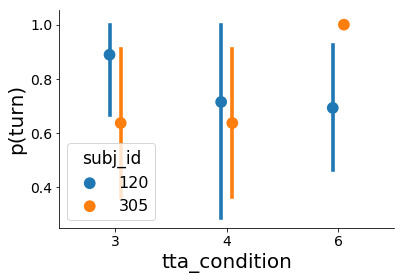

In [261]:
sns.pointplot(data=measures, x='tta_condition', y='p(turn)', hue='subj_id', join=False, dodge=0.1)

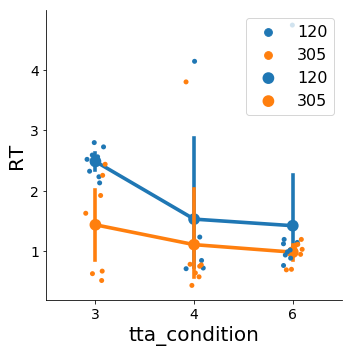

In [262]:
grid = sns.catplot(data=measures_turn, x='tta_condition', y='RT', hue='subj_id', legend=False)
ax = sns.pointplot(data=measures_turn, x='tta_condition', y='RT', hue='subj_id', ax=grid.axes[0][0], alpha=0.5)
ax.legend(loc='upper right')

We also are not sure about whether TTA is the right perceptual quantity that describes the information that the drivers use when making a decision. It can be, for instance, another combination of d and v. Let's take a look at them separately

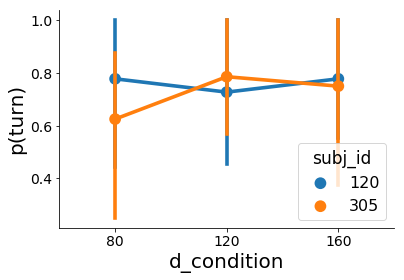

In [263]:
sns.pointplot(data=measures, x='d_condition', y='p(turn)', hue='subj_id')

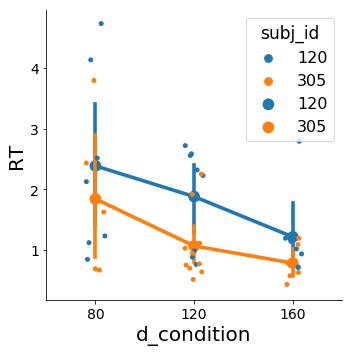

In [264]:
grid = sns.catplot(data=measures_turn, x='d_condition', y='RT', hue='subj_id', legend=False)
ax = sns.pointplot(data=measures_turn, x='d_condition', y='RT', hue='subj_id', ax=grid.axes[0][0], alpha=0.5)

In [256]:
measures_turn[measures_turn.RT>3]

,subj_id,session,route,intersection,idx_bot_spawn,idx_response,idx_min_distance,RT,tta_condition,d_condition,v_condition,p(turn)
8,120,1,1,24,46.0,507.0,582.0,4.735,6,80,13,True
9,120,1,2,2,50.0,453.0,490.0,4.136,4,80,17,True
37,305,1,2,7,80.0,449.0,488.0,3.796,4,80,17,True
